In [1]:
from keras.models import load_model
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from PIL import Image
import numpy as np 
import os

model = load_model('german_model.h5')




Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [14]:

INPUT_SIZE = 30
image_dir = '../../traffic_data'
#Predicting with the test data
y_test=pd.read_csv(image_dir+"/Test.csv")
#labels=y_test['Path'].as_matrix()
labels=y_test['Path'].values
y_test=y_test['ClassId'].values

data=[]

for f in labels:
    image=cv2.imread('../../traffic_data/test/'+f.replace('Test/', ''))
    image_from_array = Image.fromarray(image, 'RGB')
    size_image = image_from_array.resize((INPUT_SIZE, INPUT_SIZE))
    data.append(np.array(size_image))

X_test=np.array(data)
X_test = X_test.astype('float32')/255 
pred = model.predict_classes(X_test)

In [5]:

#Accuracy with the test data
from sklearn.metrics import accuracy_score
accuracy_score(y_test, pred)


# In[261]:


# Confussion matrix 
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=75) 
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# class_names = range(43)
# cm = confusion_matrix(pred,y_test)

# plt.figure(2)
# plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')


# In[262]:


import matplotlib.image as mpimg
import glob
from skimage.feature import hog
import random
from scipy import ndimage
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=1):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    
    for bbox in bboxes:
        r=random.randint(0,255)
        g=random.randint(0,255)
        b=random.randint(0,255)
        color=(r, g, b)
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


# In[263]:
Window_size = 55


# General method to extact the HOG of the image

def GetFeaturesFromHog(image,orient,cellsPerBlock,pixelsPerCell, visualise= False, feature_vector_flag=True):
    if(visualise==True):
        hog_features, hog_image = hog(image, orientations=orient,
                          pixels_per_cell=(pixelsPerCell, pixelsPerCell), 
                          cells_per_block=(cellsPerBlock, cellsPerBlock), 
                          visualise=True, feature_vector=feature_vector_flag)
        return hog_features, hog_image
    else:
        hog_features = hog(image, orientations=orient,
                          pixels_per_cell=(pixelsPerCell, pixelsPerCell), 
                          cells_per_block=(cellsPerBlock, cellsPerBlock), 
                          visualise=False, feature_vector=feature_vector_flag)
        return hog_features


# In[264]:



#Convert Image Color Space. Note the colorspace parameter is like cv2.COLOR_RGB2YUV
def ConvertImageColorspace(image, colorspace):
    return cv2.cvtColor(image, colorspace)


# In[265]:


# Method to extract the features based on the choices as available in step 2

def ExtractFeatures(images,orientation,cellsPerBlock,pixelsPerCell, convertColorspace=False):
    featureList=[]
    imageList=[]
    for image in images:
        if(convertColorspace==True):
            image= cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        local_features_1=GetFeaturesFromHog(image[:,:,0],orientation,cellsPerBlock,pixelsPerCell, False, True)
        local_features_2=GetFeaturesFromHog(image[:,:,1],orientation,cellsPerBlock,pixelsPerCell, False, True)
        local_features_3=GetFeaturesFromHog(image[:,:,2],orientation,cellsPerBlock,pixelsPerCell, False, True)
        x=np.hstack((local_features_1,local_features_2,local_features_3))
        featureList.append(x)
    return featureList


# In[266]:



# function to find the windows on which we are going to run the classifier

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(Window_size, Window_size), xy_overlap=(0.9, 0.9)):
   
    if x_start_stop[0] == None:
        x_start_stop[0]=0
    if x_start_stop[1] == None:
        x_start_stop[1]=img.shape[1]
    if y_start_stop[0] ==  None:
        y_start_stop[0]= 0
    if y_start_stop[1] ==  None:
        y_start_stop[1]=img.shape[0]
    
#     print(img.shape)
    
    window_list = []
    image_width_x= x_start_stop[1] - x_start_stop[0]
    image_width_y= y_start_stop[1] - y_start_stop[0]
     
    windows_x = np.int( 1 + (image_width_x - xy_window[0])/(xy_window[0] * xy_overlap[0]))
    windows_y = np.int( 1 + (image_width_y - xy_window[1])/(xy_window[1] * xy_overlap[1]))
    
    modified_window_size= xy_window
    for i in range(0,windows_y):
        y_start = y_start_stop[0] + np.int( i * modified_window_size[1] * xy_overlap[1])
        for j in range(0,windows_x):
            x_start = x_start_stop[0] + np.int( j * modified_window_size[0] * xy_overlap[0])
            
            x1 = np.int( x_start +  modified_window_size[0])
            y1= np.int( y_start + modified_window_size[1])
            window_list.append(((x_start,y_start),(x1,y1)))
    return window_list


# In[270]:


def DrawCars(image,windows, converColorspace=False):
    refinedWindows=[]
    for window in windows:
        
        start= window[0]
        end= window[1]
        clippedImage=image[start[1]:end[1], start[0]:end[0]]
        
        if(clippedImage.shape[1] == clippedImage.shape[0] and clippedImage.shape[1]!=0):
#             clippedImage=cv2.resize(clippedImage, (INPUT_SIZE,INPUT_SIZE),interpolation = cv2.INTER_AREA )

            
            image_from_array = Image.fromarray(clippedImage, 'RGB')
            clippedImage = image_from_array.resize((INPUT_SIZE, INPUT_SIZE))
            clippedImage = np.array(clippedImage)
            clippedImage = clippedImage.astype('float32')/255 
            
#             plt.imshow(clippedImage)
#             plt.show()

            clippedImage = np.expand_dims(clippedImage, axis=0)
            predictedOutput=model.predict(clippedImage)
            predictedOutputIndex = np.argmax(predictedOutput)
#             if(predictedOutputIndex==14):

#                 print(predictedOutput)
#                 print(max(max(predictedOutput)))
#                 print(predictedOutputIndex)
            if(predictedOutputIndex==14 and max(max(predictedOutput)) > 0.9):
                refinedWindows.append(window)
        
    return refinedWindows


# In[271]:


def DrawCarsOptimised(image, image1, image2,windows, converColorspace=False):
    refinedWindows=[]
    for window in windows:
        
        start= window[0]
        end= window[1]
        clippedImage=image[start[1]:end[1], start[0]:end[0]]
        clippedImage1=image1[start[1]:end[1], start[0]:end[0]]
        clippedImage2=image2[start[1]:end[1], start[0]:end[0]]
        
        if(clippedImage.shape[1] == clippedImage.shape[0] and clippedImage.shape[1]!=0):
            
            clippedImage=cv2.resize(clippedImage, (Window_size,Window_size)).ravel()
            clippedImage1=cv2.resize(clippedImage1, (Window_size,Window_size)).ravel()
            clippedImage2=cv2.resize(clippedImage2, (Window_size,Window_size)).ravel()
            
            #f1=ExtractFeatures([clippedImage], 9 , 2 , 16,converColorspace)
            f1= np.hstack((clippedImage,clippedImage1,clippedImage2))
            f1=scaler.transform(f1.reshape(1,-1))   
            print(f1.shape)
            predictedOutput=model.predict([f1[0]])
            if(predictedOutput==14): #14 should be stop sign
                refinedWindows.append(window)
        
    return refinedWindows




(4032, 3024, 3)


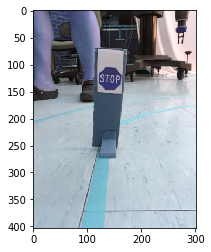

Total No of windows are  1824


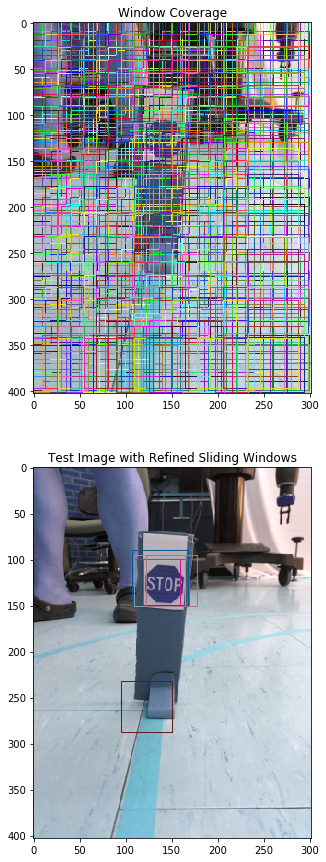

In [7]:

# In[285]:


# image = mpimg.imread('./pi_image/1.jpg')
# print(image.shape)
# image = image.resize(reso,Image.ANTIALIAS)
# image = ndimage.rotate(image, -90)

image = cv2.imread(image_dir+'/pi_image/1.jpg')
print(image.shape)

# image = cv2.resize(image,(200,200))

image = cv2.resize(image,(int((image.shape[1])/10),int(image.shape[0]/10)),interpolation = cv2.INTER_AREA )

# image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
# image = Image.fromarray(image)
# image = np.asarray(image)

plt.imshow(image)
plt.show()

# windows1 = slide_window(image, x_start_stop=[100,200], y_start_stop=[100,200], 
#                     xy_window=(50,50), xy_overlap=(0.15, 0.15))
# windows4 = slide_window(image, x_start_stop=[100,200], y_start_stop=[100,200], 
#                     xy_window=(55,55), xy_overlap=(0.15, 0.15))
# windows2 = slide_window(image, x_start_stop=[100,200], y_start_stop=[100,200], 
#                     xy_window=(60,60), xy_overlap=(0.15, 0.15))
# windows3 = slide_window(image, x_start_stop=[100,200], y_start_stop=[100,200], 
#                     xy_window=(65,65), xy_overlap=(0.15, 0.15))
# windows = windows1 + windows2 +  windows3 + windows4


windows1 = slide_window(image,   
                    xy_window=(50,50), xy_overlap=(0.20, 0.20))
windows4 = slide_window(image, 
                    xy_window=(55,55), xy_overlap=(0.25, 0.25))
windows2 = slide_window(image,  
                    xy_window=(60,60), xy_overlap=(0.30, 0.30))
windows3 = slide_window(image, 
                    xy_window=(65,65), xy_overlap=(0.40, 0.40))
windows = windows1 + windows2 +  windows3 + windows4


# windows3 = slide_window(image, 
#                     xy_window=(Window_size,Window_size), xy_overlap=(0.15, 0.15))
# windows = windows3
print("Total No of windows are ",len(windows))
refinedWindows=DrawCars(image,windows, True)



f,axes= plt.subplots(2,1, figsize=(30,15))

window_img = draw_boxes(image, windows) 

axes[0].imshow(window_img)
axes[0].set_title("Window Coverage")

window_img = draw_boxes(image, refinedWindows) 

axes[1].set_title("Test Image with Refined Sliding Windows")
axes[1].imshow(window_img)



# image = mpimg.imread('./pi_image/1.jpg')
# plt.imshow(image)
# plt.show()
# print(X_train.shape[1:])
# windows1 = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[400,464], 
#                     xy_window=(64,64), xy_overlap=(0.15, 0.15))
# windows4 = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[400,480], 
#                     xy_window=(80,80), xy_overlap=(0.2, 0.2))
# windows2 = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[400,612], 
#                     xy_window=(96,96), xy_overlap=(0.3, 0.3))
# windows3 = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[400,660], 
#                     xy_window=(128,128), xy_overlap=(0.5, 0.5))


# windows = windows1 + windows2 +  windows3 + windows4
# print("Total No of windows are ",len(windows))
# refinedWindows=DrawCars(image,windows, True)



# f,axes= plt.subplots(2,1, figsize=(30,15))

# window_img = draw_boxes(image, windows) 

# axes[0].imshow(window_img)
# axes[0].set_title("Window Coverage")

# window_img = draw_boxes(image, refinedWindows) 

# axes[1].set_title("Test Image with Refined Sliding Windows")
# axes[1].imshow(window_img)


# In[283]:




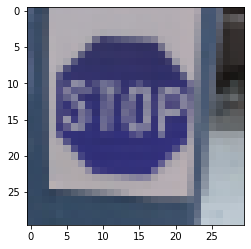

[[1.48916476e-10 9.06811238e-07 1.40120688e-08 9.29680880e-07
  1.95188332e-12 8.34038815e-07 7.27613025e-10 4.66422994e-12
  6.07959082e-12 1.21214621e-08 1.61671343e-10 3.32446559e-09
  8.40815630e-08 1.20422669e-07 9.99996662e-01 1.78306449e-11
  2.33317844e-11 6.45159091e-08 6.63506996e-14 3.99103530e-19
  1.06515977e-10 8.03433581e-17 5.79329549e-18 5.90382441e-16
  4.24495442e-18 5.26722559e-14 3.90723759e-17 2.23276479e-18
  1.74619542e-13 3.93339222e-10 1.02901264e-14 1.78143403e-17
  2.55182130e-07 6.15080429e-14 1.08033695e-11 1.31076180e-13
  2.09087711e-15 2.48281072e-20 8.28951762e-13 3.68640815e-17
  6.11084839e-17 1.60845580e-13 3.43732529e-12]]
14


In [15]:

image2 = cv2.imread(image_dir+'/pi_image/3.png')

image2=cv2.resize(image2, (INPUT_SIZE,INPUT_SIZE),interpolation = cv2.INTER_AREA )

# image2 = Image.fromarray(image2, 'RGB')
image_from_array = Image.fromarray(image2, 'RGB')
image2 = image_from_array.resize((INPUT_SIZE, INPUT_SIZE))
image2=np.array(image2)
image2 = image2.astype('float32')/255 

plt.imshow(image2)
plt.show()
image2 = np.expand_dims(image2, axis=0)



predicted = model.predict_proba(image2)
print(predicted)
print(np.argmax(predicted))

In [10]:
#heat map aaply

# function to increase the pixel by one inside each box

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [11]:

# applying a threshold value to the image to filter out low pixel cells

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [12]:

# find pixels with each car number and draw the final bounding boxes

from scipy.ndimage.measurements import label
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

 Number of sign found -  1


Text(0.5, 1.0, 'Final Image after applying Heat Map')

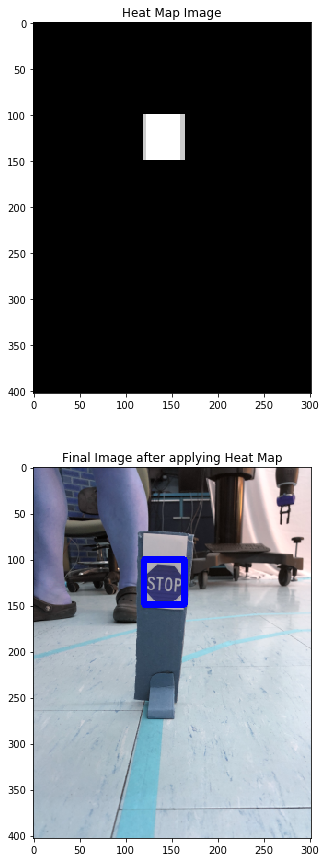

In [13]:

#testing our heat function

heat = np.zeros_like(image[:,:,0]).astype(np.float)

heat = add_heat(heat,refinedWindows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,3)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

heat_image=heatmap

# Find final boxes from heatmap using label function
labels = label(heatmap)
print(" Number of sign found - ",labels[1])
draw_img = draw_labeled_bboxes(np.copy(image), labels)

f,axes= plt.subplots(2,1, figsize=(30,15))
axes[0].imshow(heat_image,cmap='gray')
axes[0].set_title("Heat Map Image")
axes[1].imshow(draw_img)
axes[1].set_title("Final Image after applying Heat Map")

In [ ]:
print(heat.shape)
# image2 = cv2.imread('./pi_image/3.png',0)
# print(image2.shape)
# ret,thresh = cv2.threshold(heat,127,255,0)
contours,hierarchy = cv2.findContours(thresh, 1, 2) 
cnt = contours[0]